## Use of classic algorithms
The goal of this notebook is to show if it is possible to use classic algorithms (based on VFA linear methods and actor-critc methods) in the Slimevolley gym environment.

In [17]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gym
import slimevolleygym
from slimevolleygym import SurvivalRewardEnv
from algorithms import *

plt.style.use('seaborn')

# Define our input folders and output files
DATADIR = join('..', 'data')
LOGDIR = join('..', 'logs')

We create a wrapper which inherits from gym.ObservationWrapper to transform the 12-dimensional original observation space to a reduced 8-dimensional space. This way we eliminate the information from the opponent, which is not relevant for the agent operation.

In [18]:
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

slime_env = SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0')))

We create the class BoundFeaturizer, which provides the definition of feature_vector. This allows to create a feature vector from a continuous observation space, given a number of partitions and a bound. We use radial base functions.

In [19]:
class BoundFeaturizer:
    def __init__(self, observation_space, partitions = 10, sigma = 0.1, bound = 5.0):
        self.n_dim = len(observation_space.low)
        self.sigma = sigma
        offset, scale_factor = [], []
        for i in range(self.n_dim):
            lower_bound = max(-1*bound, observation_space.low[i])
            upper_bound = min(bound, observation_space.high[i])
            offset.append(-1* lower_bound)
            scale_factor.append(1/(upper_bound - lower_bound))
        self.offset = np.array(offset, dtype=np.float_)
        self.scale_factor = np.array(scale_factor ,dtype=np.float_)
        scale = np.linspace(1.0/partitions,1.0,partitions) - 0.5/partitions
        self.landmarks = np.array(list(product(scale, repeat=self.n_dim)))
        self.n_parameters = partitions**self.n_dim
    
    def feature_vector(self, s):
        s = (s + self.offset) * self.scale_factor
        dist = (self.landmarks - s)**2
        f = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return f

class ClusteringFeaturizer:
    def __init__(self, observation_space, centroids, sigma=0.5):
        self.n_dim = len(observation_space.low)
        self.centroids = np.array(centroids)     
        self.sigma = sigma
        self.n_parameters = len(self.centroids)
        
    def feature_vector(self, s):
        dist = (self.centroids - np.array(s))**2
        x = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return x

In [20]:
featurizer = BoundFeaturizer(slime_env.observation_space, 3, sigma = 0.2, bound = 2.0)

In [21]:
centroids_5k = pd.read_csv(join(DATADIR, 'c_5_mix.csv'))
centroids_10k = pd.read_csv(join(DATADIR, 'c_10_mix.csv'))
centroids_25k = pd.read_csv(join(DATADIR, 'c_25_mix.csv'))

In [22]:
featurizer_5 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_5k), sigma=0.3)
featurizer_10 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_10k), sigma=0.3)
featurizer_25 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_25k), sigma=0.3)

##### Example: plot of feature vector from sampled states

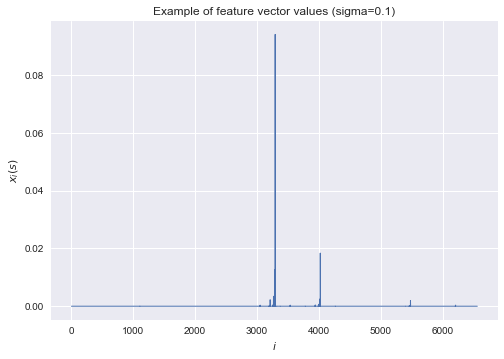

In [31]:
ss_bsln = pd.read_csv(join(DATADIR, 'ss_bsln_900k.csv')).iloc[:, :8]
ss_random = pd.read_csv(join(DATADIR, 'ss_random_100k.csv')).iloc[:, :8]
ss = pd.concat([ss_bsln, ss_random], ignore_index=True).sample(frac=1).to_numpy()

featurizer_test = BoundFeaturizer(slime_env.observation_space, 3, sigma = 0.1, bound = 2.0)
x = featurizer_test.feature_vector(ss[0, :])

fix, ax = plt.subplots()
ax.plot(x, linewidth=1)
ax.set_title('Example of feature vector values (sigma=0.1)')
ax.set_ylabel('$x_i(s)$')
ax.set_xlabel('$i$');

In [9]:
def plot_results(rewards, lengths, title):
    rewards_avg = pd.DataFrame(rewards).expanding().mean()
    lengths_avg = pd.DataFrame(lengths).expanding().mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.set_title(title)

    ax1.plot(rewards, label='Reward per episode')
    ax1.plot(rewards_avg, label='Overall mean reward')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Reward')
    ax1.legend(loc='upper left')

    ax2.plot(lengths, label='Length per episode')
    ax2.plot(lengths_avg, label='Overall mean length')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Timesteps')
    ax2.legend(loc='upper left');
    

def save_results(rewards, lengths, file_name):
    training_data = np.vstack((rewards, lengths)).T
    np.savetxt(join(LOGDIR, 'classic', file_name), training_data, delimiter=',',
               header='rewards,lengths', comments='')

### SARSA-LAMBDA

##### TEST 1: lambda = 0.99; alpha, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [47]:
save_results(slime_rewards, slime_lengths, 'test1.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test1.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.1; epsilon=0.1")

##### TEST 2: lambda = 0.99; alpha, epsilon = 0.3

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [50]:
save_results(slime_rewards, slime_lengths, 'test2.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test2.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.3; epsilon=0.3")

##### TEST 3: lambda = 0.99; alpha, epsilon = 0.5

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [53]:
save_results(slime_rewards, slime_lengths, 'test3.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test3.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.5; epsilon=0.5")

##### TEST 4: lambda = 0.9; alpha, epsilon = 0.1

In [6]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths, best_params = sarsa_lambda(slime_env, q, 2_000_000,
                                                        gamma=1, epsilon=0.1, alpha=0.1)

episodio 1: alfa = 0.09939284761975255, epsilon = 0.09939284761975255, rew_ep = 1.0900000000000032, len_ep = 609, total_t = 609
episodio 2: alfa = 0.09874987353159767, epsilon = 0.09874987353159767, rew_ep = 2.4899999999999, len_ep = 649, total_t = 1258
episodio 3: alfa = 0.09818074278926046, epsilon = 0.09818074278926046, rew_ep = 0.7799999999999998, len_ep = 578, total_t = 1836
episodio 4: alfa = 0.09730886057988496, epsilon = 0.09730886057988496, rew_ep = 3.9199999999998623, len_ep = 892, total_t = 2728
episodio 5: alfa = 0.09675674266767928, epsilon = 0.09675674266767928, rew_ep = 0.6900000000000044, len_ep = 569, total_t = 3297
episodio 6: alfa = 0.09633098279425635, epsilon = 0.09633098279425635, rew_ep = -0.5899999999999974, len_ep = 441, total_t = 3738
episodio 7: alfa = 0.09573078871109474, epsilon = 0.09573078871109474, rew_ep = 1.2499999999999496, len_ep = 625, total_t = 4363
episodio 8: alfa = 0.0951571692559113, epsilon = 0.0951571692559113, rew_ep = 1.0100000000000031, le

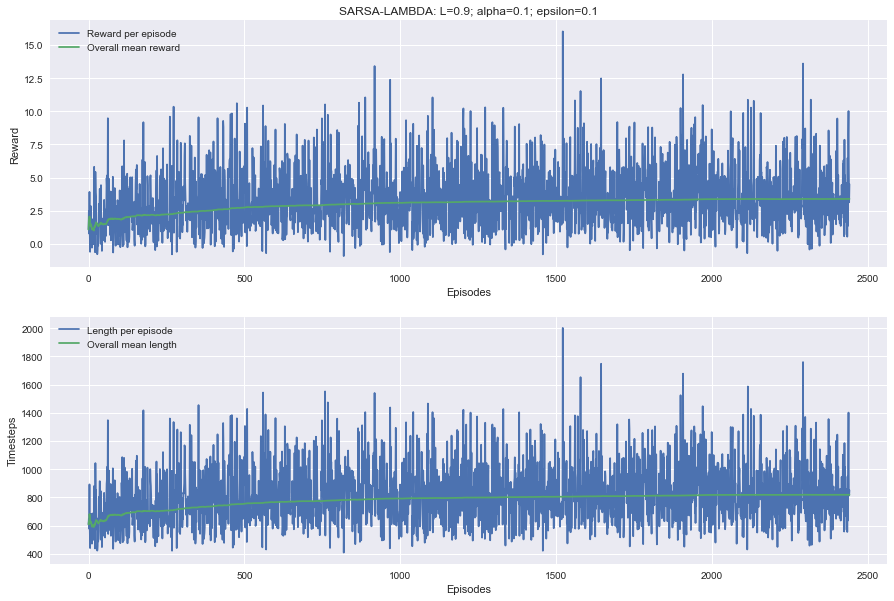

In [7]:
plot_results(slime_rewards, slime_lengths,
             "SARSA-LAMBDA: L=0.9; alpha=0.1; epsilon=0.1")

In [24]:
def evaluate_algorithm(env, q, episodes):
    rewards = np.zeros(episodes)
    lengths = np.zeros(episodes)
    ep = 0
    for i in range(episodes):
        S = env.reset()
        G = 0
        t = 0
        ep += 1
        done = False
        if ep % 50 == 0:
            print('episode {}'.format(i))
        while not done:
            A = get_action(S, q)
            S, R, done, _ = env.step(A)
            G += R
            t += 1
        rewards[i] = G
        lengths[i] = t
    return rewards, lengths

In [ ]:
slime_env_gym = ReducedDimension(gym.make('SlimeVolley-v0'))
slime_q.parameters = best_params
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, slime_q, 1000)

In [ ]:
eval_rew.mean()

In [12]:
save_results(slime_rewards, slime_lengths, 'test4.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test4.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.1; epsilon=0.1")

##### TEST 5: lambda = 0.9; alpha, epsilon = 0.3

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [17]:
save_results(slime_rewards, slime_lengths, 'test5.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test5.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.3; epsilon=0.3")

##### TEST 6: lambda = 0.9; alpha, epsilon = 0.5

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [20]:
save_results(slime_rewards, slime_lengths, 'test6.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test6.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.5; epsilon=0.5")

##### TEST 7: lambda = 0.7; alpha, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [23]:
save_results(slime_rewards, slime_lengths, 'test7.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test7.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.1; epsilon=0.1")

##### TEST 8: lambda = 0.7; alpha, epsilon = 0.3

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [26]:
save_results(slime_rewards, slime_lengths, 'test8.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test8.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.3; epsilon=0.3")

##### TEST 9: lambda = 0.7; alpha, epsilon = 0.5

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [29]:
save_results(slime_rewards, slime_lengths, 'test9.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test9.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.5; epsilon=0.5")

##### TEST 10: lambda = 0.9; alpha = 0.03, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.03)

In [19]:
save_results(slime_rewards, slime_lengths, 'test10.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test10.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.03; epsilon=0.1")

##### TEST 11: lambda = 0.9; alpha = 0.01, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.01)

In [22]:
save_results(slime_rewards, slime_lengths, 'test11.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test11.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.01; epsilon=0.1")

##### TEST 12: lambda = 0.95; alpha = 0.1, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.95)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [35]:
save_results(slime_rewards, slime_lengths, 'test12.csv')

In [ ]:
slime_info = pd.read_csv(join(LOGDIR, 'test12.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.95; alpha=0.1; epsilon=0.1")

##### TEST 13: lambda = 0.9; alpha = 0.2, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.2)

In [102]:
save_results(slime_rewards, slime_lengths, 'test13.csv')

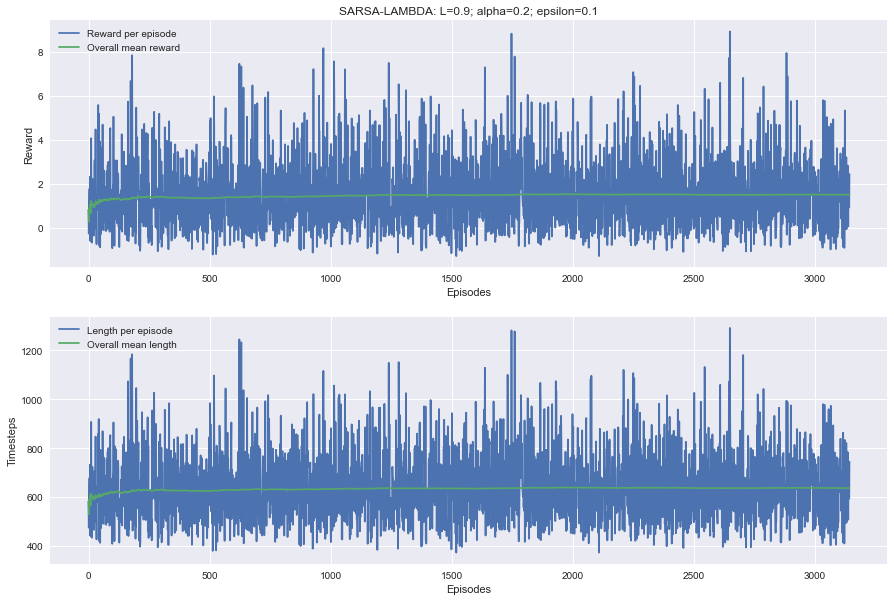

In [111]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test13.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.2; epsilon=0.1")

##### TEST 14: lambda = 0.9; alpha, epsilon = 0.1, clustering centroids (10K)

In [ ]:
q = LambdaValueFunction(featurizer_10, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [105]:
save_results(slime_rewards, slime_lengths, 'test14.csv')

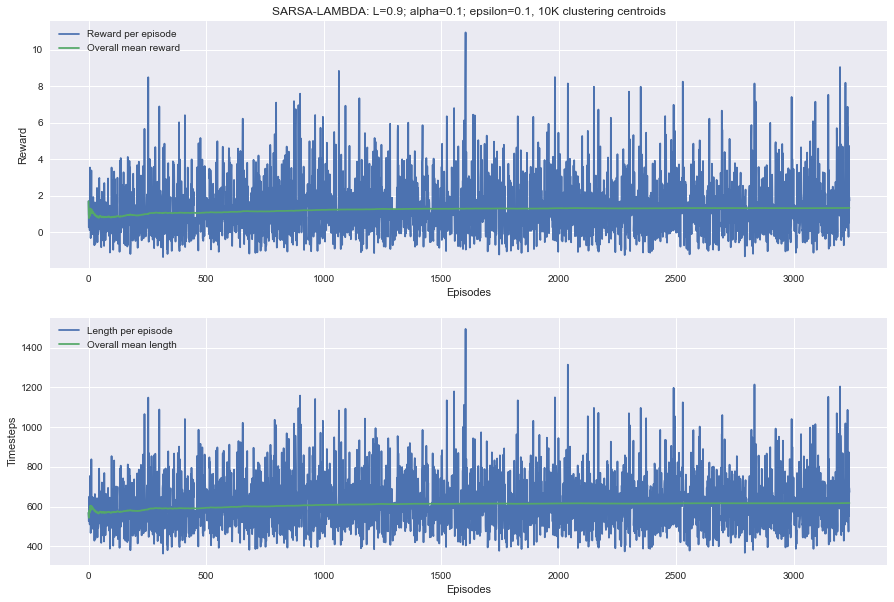

In [112]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test14.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.1; epsilon=0.1, 10K clustering centroids")

##### TEST 15: lambda = 0.9; alpha, epsilon = 0.3, clustering centroids (10K)

In [ ]:
q = LambdaValueFunction(featurizer_10, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [108]:
save_results(slime_rewards, slime_lengths, 'test15.csv')

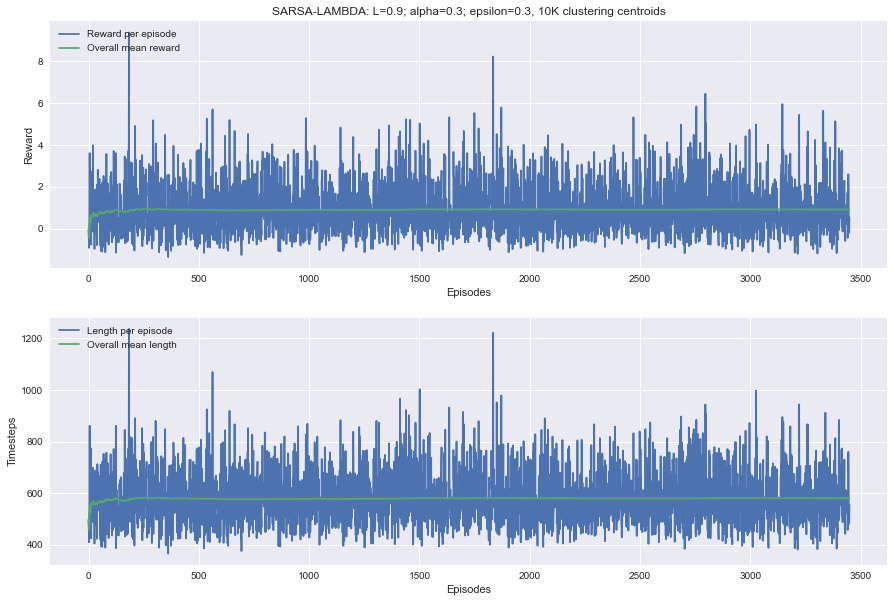

In [113]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test15.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.3; epsilon=0.3, 10K clustering centroids")

##### TEST 16: lambda = 0.9; alpha, epsilon = 0.5, clustering centroids (10K)

In [ ]:
q = LambdaValueFunction(featurizer_10, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [116]:
save_results(slime_rewards, slime_lengths, 'test16.csv')

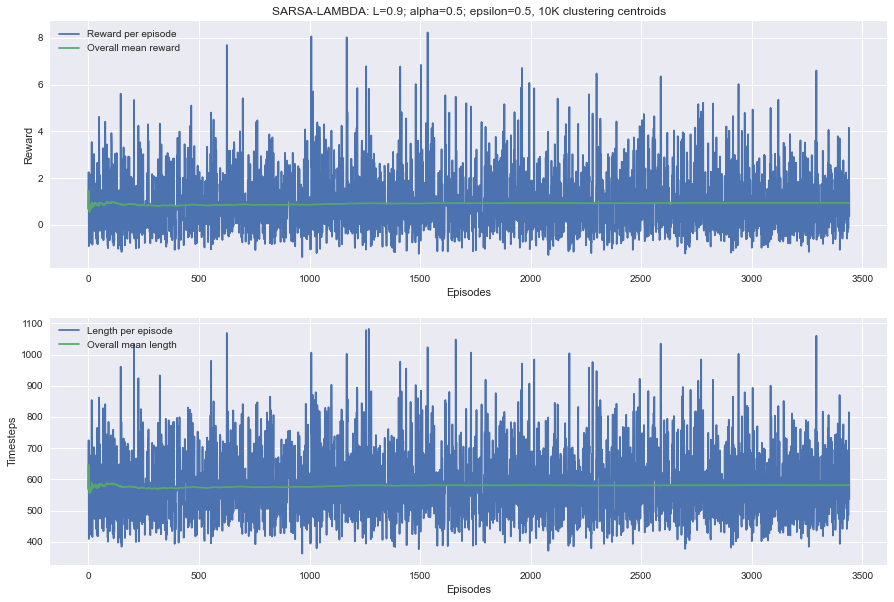

In [118]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test16.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.5; epsilon=0.5, 10K clustering centroids")

#### Results

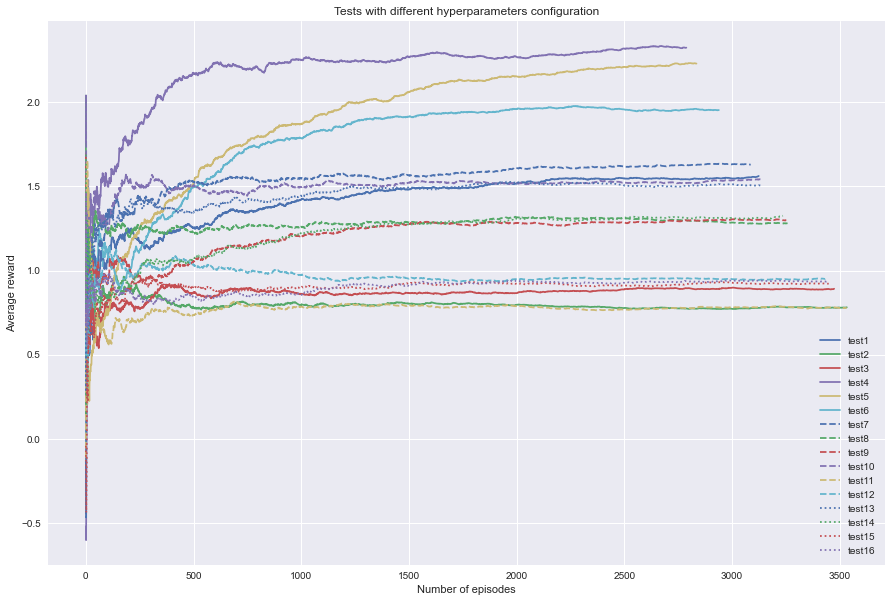

In [3]:
slime_avg_rews = pd.DataFrame({
    "test1": pd.read_csv(join(LOGDIR, 'classic', 'test1.csv')).loc[:, 'rewards'].expanding().mean(),
    "test2": pd.read_csv(join(LOGDIR, 'classic', 'test2.csv')).loc[:, 'rewards'].expanding().mean(),
    "test3": pd.read_csv(join(LOGDIR, 'classic', 'test3.csv')).loc[:, 'rewards'].expanding().mean(),
    "test4": pd.read_csv(join(LOGDIR, 'classic', 'test4.csv')).loc[:, 'rewards'].expanding().mean(),
    "test5": pd.read_csv(join(LOGDIR, 'classic', 'test5.csv')).loc[:, 'rewards'].expanding().mean(),
    "test6": pd.read_csv(join(LOGDIR, 'classic', 'test6.csv')).loc[:, 'rewards'].expanding().mean(),
    "test7": pd.read_csv(join(LOGDIR, 'classic', 'test7.csv')).loc[:, 'rewards'].expanding().mean(),
    "test8": pd.read_csv(join(LOGDIR, 'classic', 'test8.csv')).loc[:, 'rewards'].expanding().mean(),
    "test9": pd.read_csv(join(LOGDIR, 'classic', 'test9.csv')).loc[:, 'rewards'].expanding().mean(),
    "test10": pd.read_csv(join(LOGDIR, 'classic', 'test10.csv')).loc[:, 'rewards'].expanding().mean(),
    "test11": pd.read_csv(join(LOGDIR, 'classic', 'test11.csv')).loc[:, 'rewards'].expanding().mean(),
    "test12": pd.read_csv(join(LOGDIR, 'classic', 'test12.csv')).loc[:, 'rewards'].expanding().mean(),
    "test13": pd.read_csv(join(LOGDIR, 'classic', 'test13.csv')).loc[:, 'rewards'].expanding().mean(),
    "test14": pd.read_csv(join(LOGDIR, 'classic', 'test14.csv')).loc[:, 'rewards'].expanding().mean(),
    "test15": pd.read_csv(join(LOGDIR, 'classic', 'test15.csv')).loc[:, 'rewards'].expanding().mean(),
    "test16": pd.read_csv(join(LOGDIR, 'classic', 'test16.csv')).loc[:, 'rewards'].expanding().mean()
})

fig, ax = plt.subplots(figsize=(15, 10))

for i in range(slime_avg_rews.shape[1]):
    if(i<6):
        ax.plot(slime_avg_rews.iloc[:, i], linestyle='solid', label='test'+str(i+1))
    elif(i>=6 and i<12):
        ax.plot(slime_avg_rews.iloc[:, i], linestyle='dashed', label='test'+str(i+1))
    else:
        ax.plot(slime_avg_rews.iloc[:, i], linestyle='dotted', label='test'+str(i+1))
    
ax.legend(loc='lower right')
ax.set_title('Tests with different hyperparameters configuration')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average reward');

### ACTOR-CRITIC (LAMBDA)

##### TEST 17: lambda_actor/critic = 0.5; alpha = 0.0005; beta = 0.0025

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)

In [31]:
save_results(slime_rewards, slime_lengths, 'test17.csv')

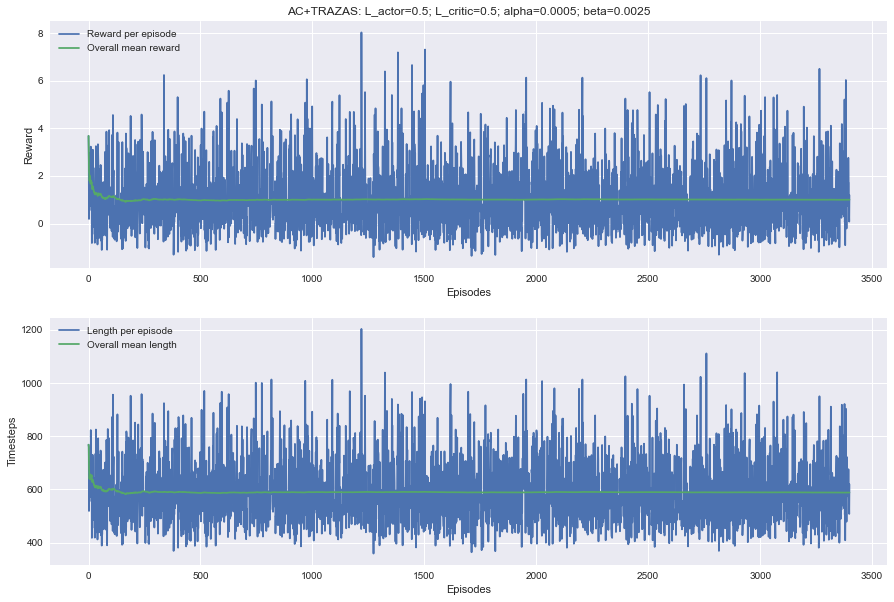

In [32]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test17.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.5; L_critic=0.5; alpha=0.0005; beta=0.0025")

##### TEST 18: lambda_actor/critic = 0.5; alpha = 0.001; beta = 0.005

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [34]:
save_results(slime_rewards, slime_lengths, 'test18.csv')

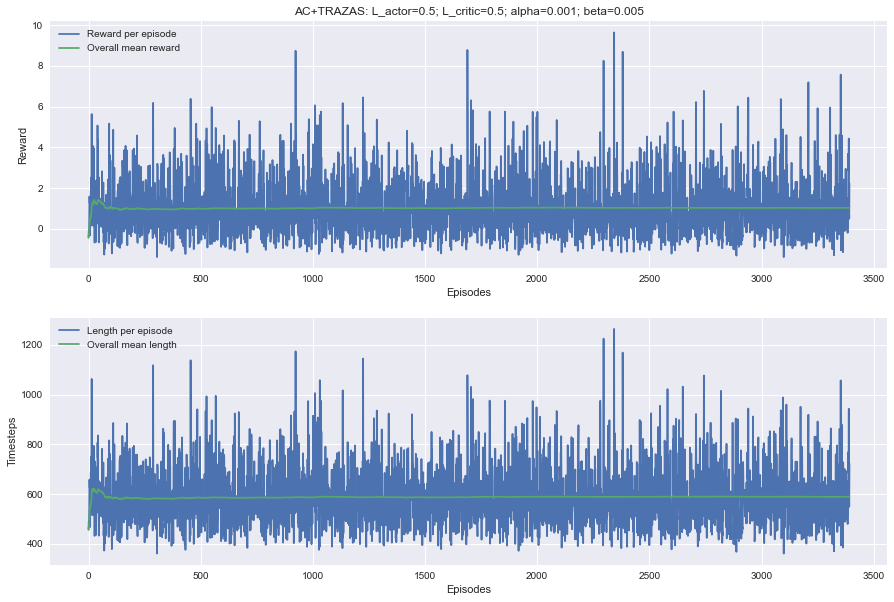

In [35]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test18.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.5; L_critic=0.5; alpha=0.001; beta=0.005")

##### TEST 19: lambda_actor/critic = 0.5; alpha = 0.01; beta = 0.05

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.01, beta=0.05, gamma = 1)

In [37]:
save_results(slime_rewards, slime_lengths, 'test19.csv')

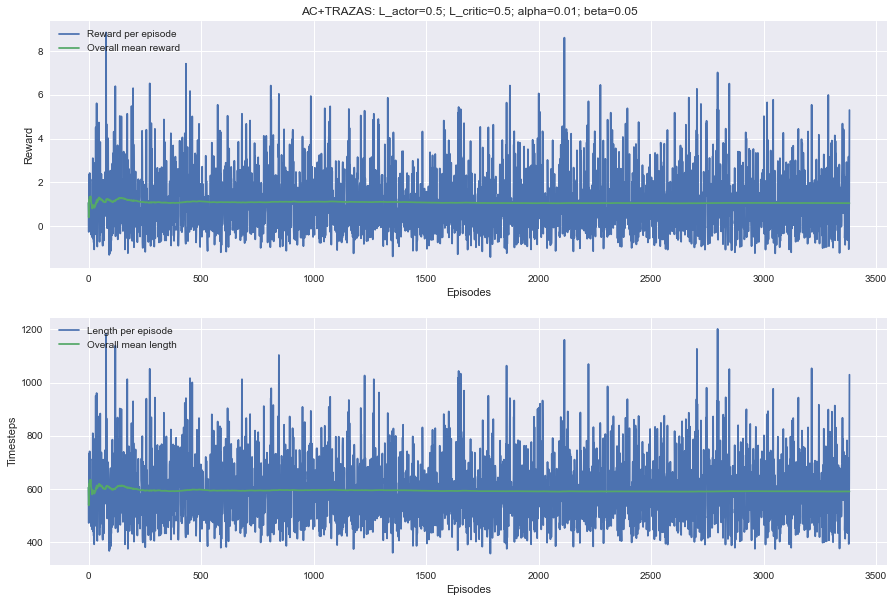

In [38]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test19.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.5; L_critic=0.5; alpha=0.01; beta=0.05")

##### TEST 20: lambda_actor/critic = 0.6; alpha = 0.0005; beta = 0.0025

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.6)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.6)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)

In [40]:
save_results(slime_rewards, slime_lengths, 'test20.csv')

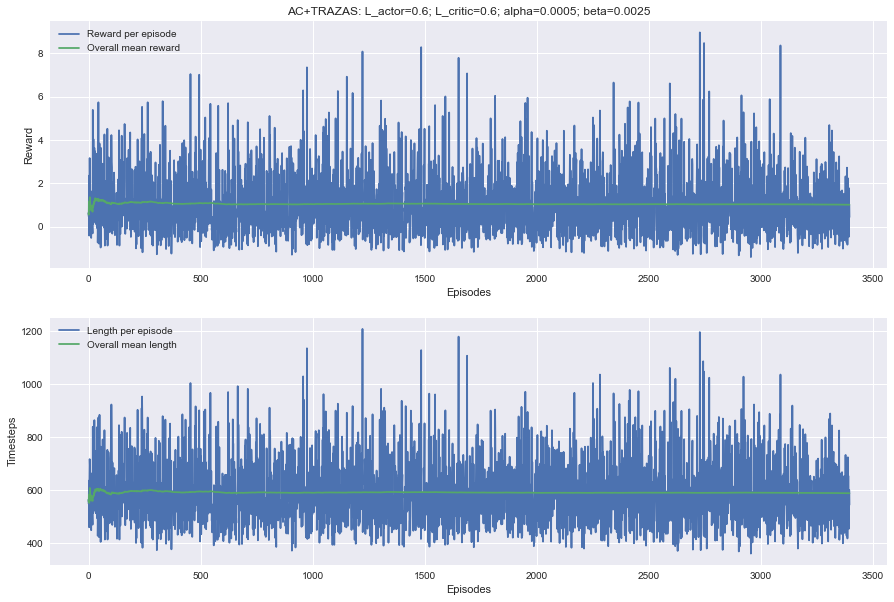

In [41]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test20.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.6; L_critic=0.6; alpha=0.0005; beta=0.0025")

##### TEST 21: lambda_actor/critic = 0.6; alpha = 0.001; beta = 0.005

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.6)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.6)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [43]:
save_results(slime_rewards, slime_lengths, 'test21.csv')

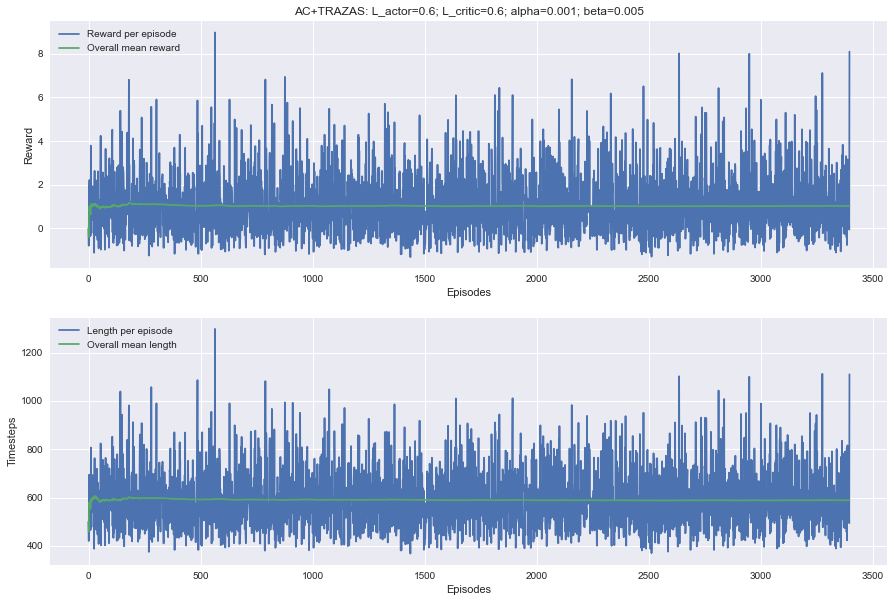

In [44]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test21.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.6; L_critic=0.6; alpha=0.001; beta=0.005")

##### TEST 22: lambda_actor/critic = 0.6; alpha = 0.01; beta = 0.05

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.6)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.6)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.01, beta=0.05, gamma = 1)

In [46]:
save_results(slime_rewards, slime_lengths, 'test22.csv')

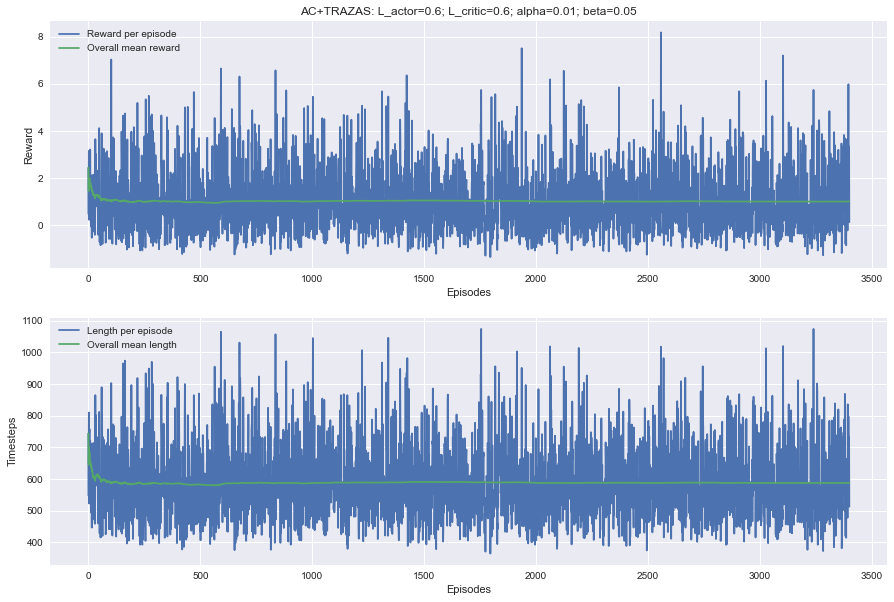

In [47]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test22.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.6; L_critic=0.6; alpha=0.01; beta=0.05")

##### TEST 23: lambda_actor/critic = 0.8; alpha = 0.0005; beta = 0.0025

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.8)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.8)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)

In [49]:
save_results(slime_rewards, slime_lengths, 'test23.csv')

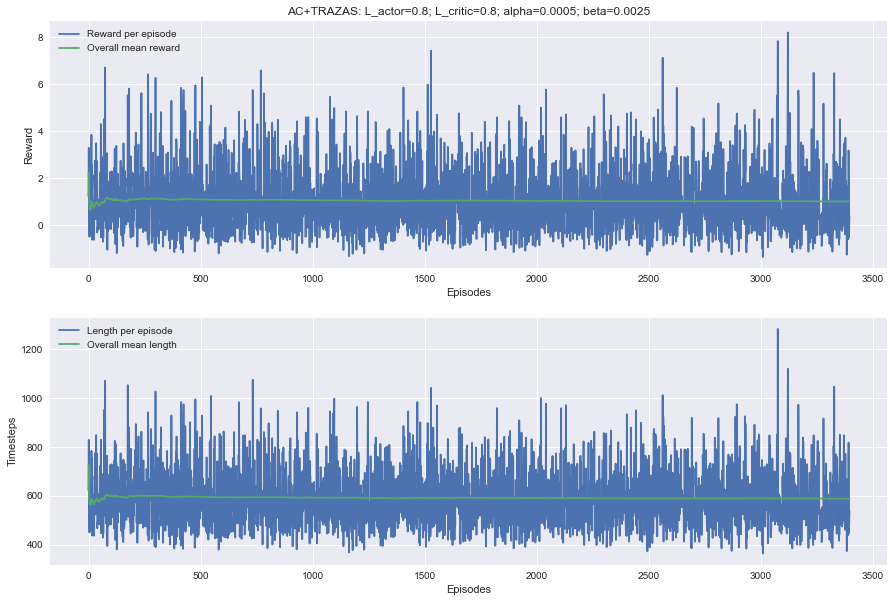

In [50]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test23.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.8; L_critic=0.8; alpha=0.0005; beta=0.0025")

##### TEST 24: lambda_actor/critic = 0.8; alpha = 0.001; beta = 0.005

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.8)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.8)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [52]:
save_results(slime_rewards, slime_lengths, 'test24.csv')

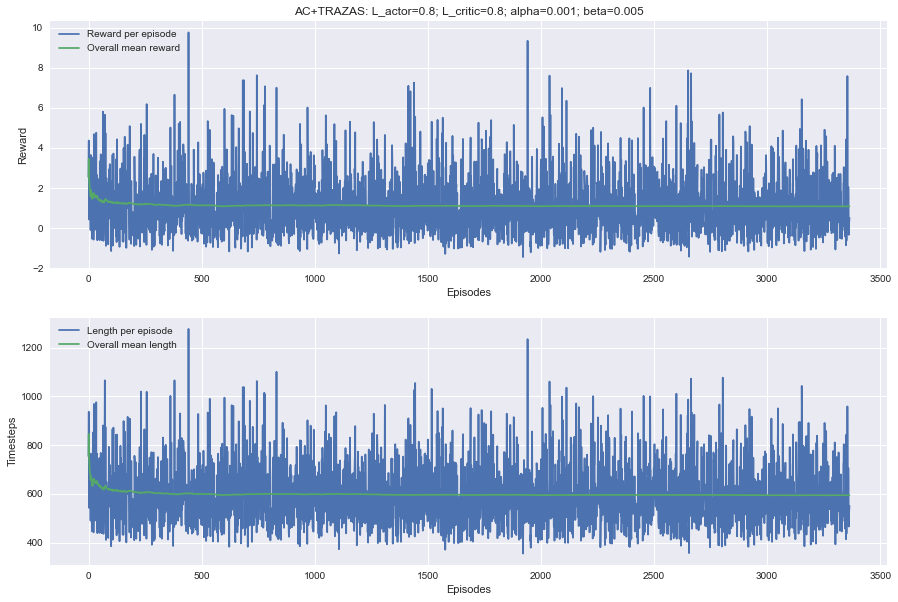

In [53]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test24.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.8; L_critic=0.8; alpha=0.001; beta=0.005")

##### TEST 25: lambda_actor/critic = 0.8; alpha = 0.01; beta = 0.05

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.8)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.8)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.01, beta=0.05, gamma = 1)

In [55]:
save_results(slime_rewards, slime_lengths, 'test25.csv')

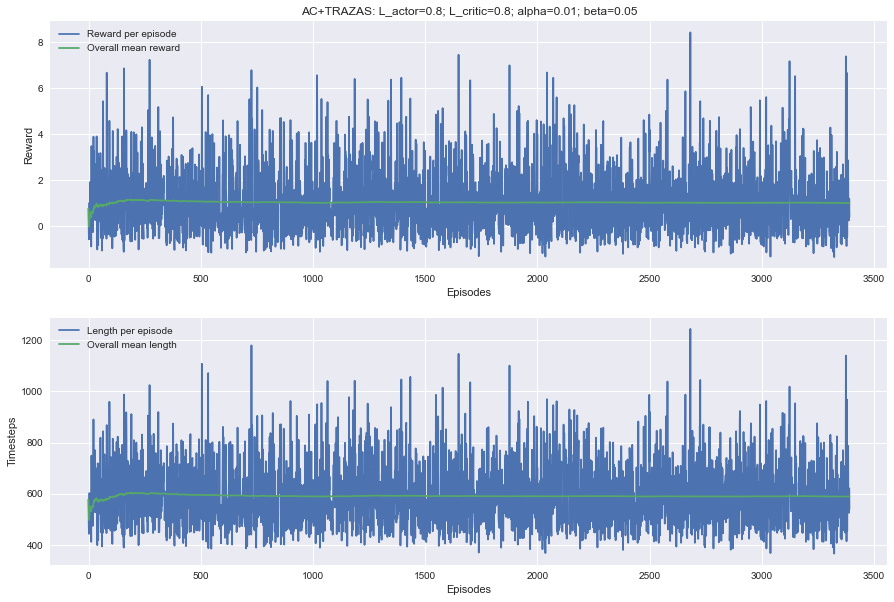

In [56]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test25.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.8; L_critic=0.8; alpha=0.01; beta=0.05")

##### TEST 26: lambda_actor/critic = 0.9; alpha = 0.001; beta = 0.005

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.9)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.9)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [60]:
save_results(slime_rewards, slime_lengths, 'test26.csv')

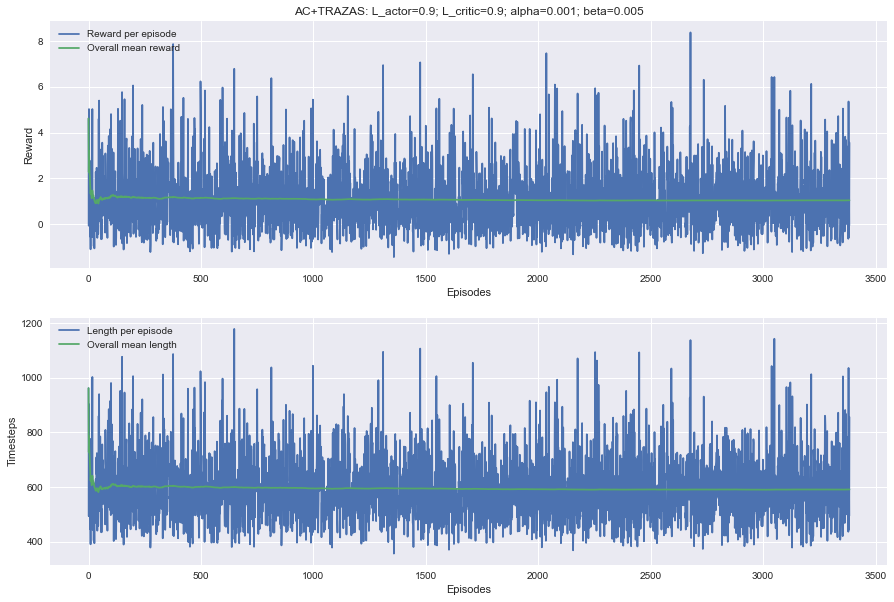

In [61]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test26.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.9; L_critic=0.9; alpha=0.001; beta=0.005")

##### TEST 27: lambda_actor/critic = 0.95; alpha = 0.001; beta = 0.005

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.95)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.95)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [63]:
save_results(slime_rewards, slime_lengths, 'test27.csv')

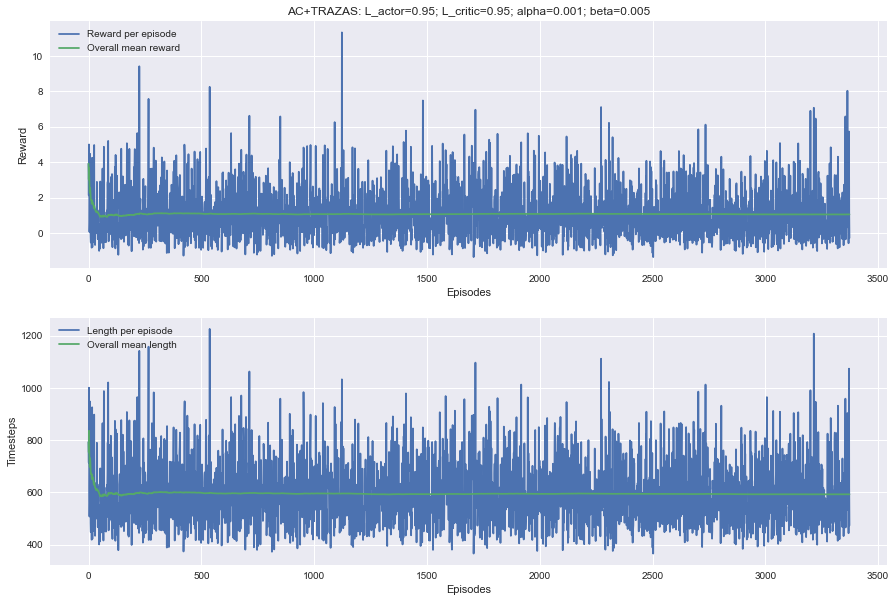

In [64]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test27.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.95; L_critic=0.95; alpha=0.001; beta=0.005")

##### TEST 28: lambda_actor/critic = 0.8; alpha = 0.001; beta = 0.005; sampled centroids (5K)

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer_5, slime_env.action_space.n, L=0.8)   # L_actor
v = LambdaValueFunctionAC(featurizer_5, L=0.8)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [11]:
save_results(slime_rewards, slime_lengths, 'test28.csv')

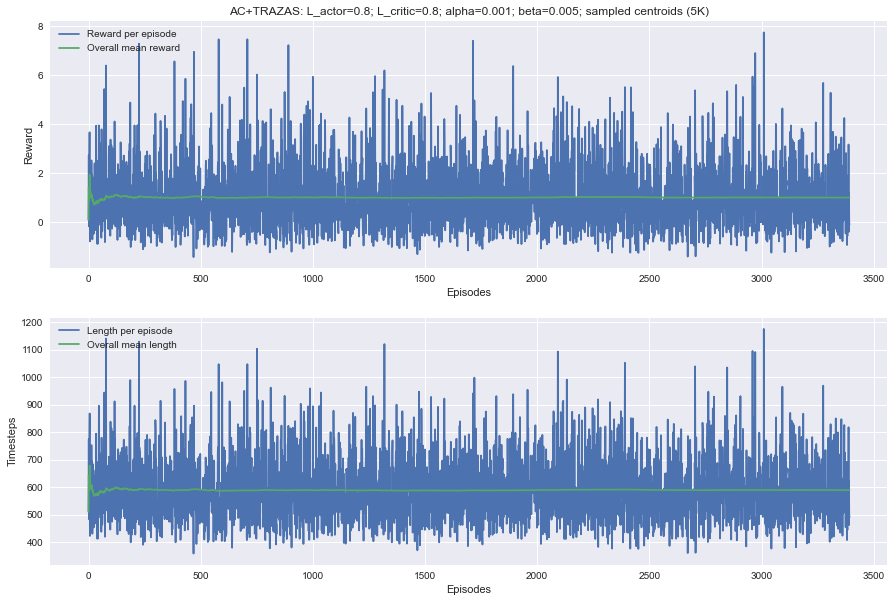

In [12]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test28.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.8; L_critic=0.8; alpha=0.001; beta=0.005; sampled centroids (5K)")

##### TEST 29: lambda_actor/critic = 0.8; alpha = 0.001; beta = 0.005; sampled centroids (10K)

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer_10, slime_env.action_space.n, L=0.8)   # L_actor
v = LambdaValueFunctionAC(featurizer_10, L=0.8)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 1)

In [14]:
save_results(slime_rewards, slime_lengths, 'test29.csv')

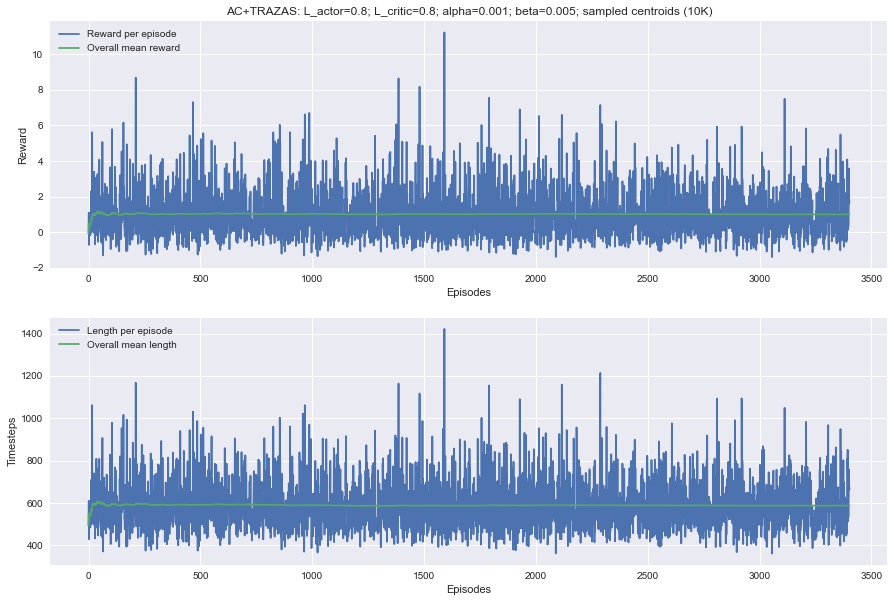

In [15]:
slime_info = pd.read_csv(join(LOGDIR, 'classic', 'test29.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "AC+TRAZAS: L_actor=0.8; L_critic=0.8; alpha=0.001; beta=0.005; sampled centroids (10K)")

#### Results

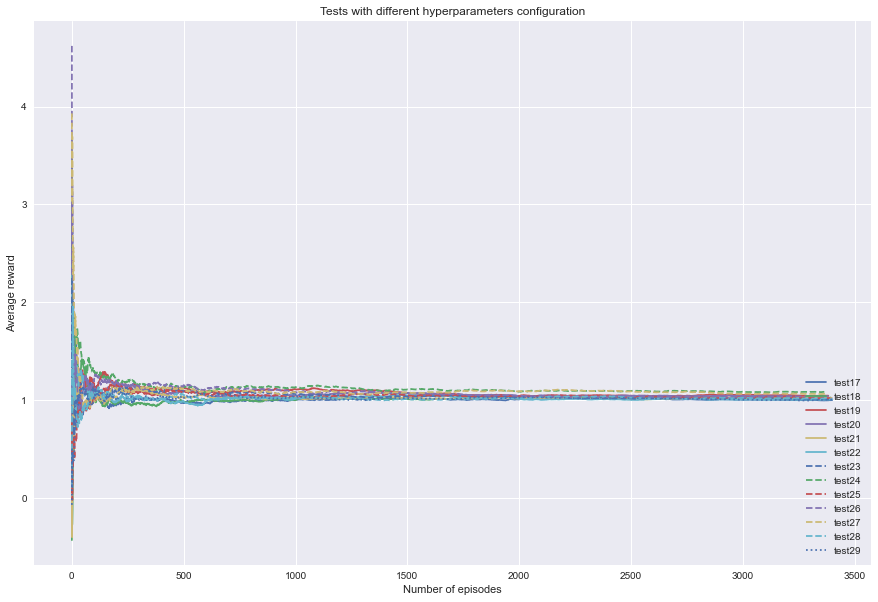

In [16]:
slime_avg_rews = pd.DataFrame({
    "test17": pd.read_csv(join(LOGDIR, 'classic', 'test17.csv')).loc[:, 'rewards'].expanding().mean(),
    "test18": pd.read_csv(join(LOGDIR, 'classic', 'test18.csv')).loc[:, 'rewards'].expanding().mean(),
    "test19": pd.read_csv(join(LOGDIR, 'classic', 'test19.csv')).loc[:, 'rewards'].expanding().mean(),
    "test20": pd.read_csv(join(LOGDIR, 'classic', 'test20.csv')).loc[:, 'rewards'].expanding().mean(),
    "test21": pd.read_csv(join(LOGDIR, 'classic', 'test21.csv')).loc[:, 'rewards'].expanding().mean(),
    "test22": pd.read_csv(join(LOGDIR, 'classic', 'test22.csv')).loc[:, 'rewards'].expanding().mean(),
    "test23": pd.read_csv(join(LOGDIR, 'classic', 'test23.csv')).loc[:, 'rewards'].expanding().mean(),
    "test24": pd.read_csv(join(LOGDIR, 'classic', 'test24.csv')).loc[:, 'rewards'].expanding().mean(),
    "test25": pd.read_csv(join(LOGDIR, 'classic', 'test25.csv')).loc[:, 'rewards'].expanding().mean(),
    "test26": pd.read_csv(join(LOGDIR, 'classic', 'test26.csv')).loc[:, 'rewards'].expanding().mean(),
    "test27": pd.read_csv(join(LOGDIR, 'classic', 'test27.csv')).loc[:, 'rewards'].expanding().mean(),
    "test28": pd.read_csv(join(LOGDIR, 'classic', 'test28.csv')).loc[:, 'rewards'].expanding().mean(),
    "test29": pd.read_csv(join(LOGDIR, 'classic', 'test29.csv')).loc[:, 'rewards'].expanding().mean()
})

fig, ax = plt.subplots(figsize=(15, 10))

for i in range(slime_avg_rews.shape[1]):
    if(i<6):
        ax.plot(slime_avg_rews.iloc[:, i], linestyle='solid', label='test'+str(i+17))
    elif(i>=6 and i<12):
        ax.plot(slime_avg_rews.iloc[:, i], linestyle='dashed', label='test'+str(i+17))
    else:
        ax.plot(slime_avg_rews.iloc[:, i], linestyle='dotted', label='test'+str(i+17))
    
ax.legend(loc='lower right')
ax.set_title('Tests with different hyperparameters configuration')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average reward');